In [55]:
%matplotlib inline
import numpy as np

caffe_root = '../../../caffe/'

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

import matplotlib.pyplot as plt

import time

In [56]:
import os
np_loaded_data_file = '../data/train_data_cleaned_data_aug_flip.npz'
if not os.path.isfile(np_loaded_data_file):
    print "%s does not exist. See facial_recog_kaggle.ipynb" % np_loaded_data_file
else:
    print "loading %s" % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    print "loaded: ", npzfile.files
    X_train_clean_cv, y_train_clean_cv = npzfile['X_train_clean_cv'], npzfile['y_train_clean_cv']
    X_val_clean_cv, y_val_clean_cv = npzfile['X_val_clean_cv'], npzfile['y_val_clean_cv']
    feature_labels = npzfile['feature_labels']
    print X_train_clean_cv.shape, y_train_clean_cv.shape
    print X_val_clean_cv.shape, y_val_clean_cv.shape
    

loading ../data/train_data_cleaned_data_aug_flip.npz
loaded:  ['X_val_clean_cv', 'y_val_clean_cv', 'y_train_clean_cv', 'feature_labels', 'X_train_clean_cv']
(3448, 1, 96, 96) (3448, 30)
(832, 1, 96, 96) (832, 30)


In [57]:
batch_size = 64

td_size = ( X_train_clean_cv.shape[0] // batch_size) * batch_size
# print td_size
# td_size = 256
val_data_size, num_labels = y_val_clean_cv.shape


# val_data_size = 2*batch_size


#Define all params for training
DEBUG_MSGS = 0
dropout_ratio = 0.5
num_epochs = 25
min_epochs = 50
auto_stop = False

base_lr = 5.41e-4
stepsize_in_epoch = 25 #drop learning rate once every stepsize_in_epoch epochs
stepsize = (td_size // batch_size) * stepsize_in_epoch
gamma = 0.5





reg_param = 0 * 4.641589e-03


train_suffix = "__b_lr_%.02e__reg_param_%0.02e__batch_size_%d__drop_%.02e_" % (base_lr, reg_param, batch_size, dropout_ratio)
train_suffix = train_suffix + time.strftime("%Y%m%d%H%M")
print train_suffix

__b_lr_5.41e-04__reg_param_0.00e+00__batch_size_64__drop_5.00e-01_201610242152


In [58]:
from caffe import layers as L, params as P

def lenet(hdf5_list, batch_size=64, dropout_ratio=0.5, train=True):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5_list, ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=3, num_output=32, weight_filler=dict(type='xavier'), bias_filler=dict(type='constant', value=0.1))
    n.relu1 = L.ReLU(n.conv1, in_place=False, relu_param=dict(negative_slope=0.1))
    n.pool1 = L.Pooling(n.relu1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.bn1   = L.BatchNorm(n.pool1, batch_norm_param=dict(use_global_stats = (train==False)))
    
    n.conv2 = L.Convolution(n.bn1, kernel_size=3, num_output=64, weight_filler=dict(type='xavier'), bias_filler=dict(type='constant', value=0.1))
    n.relu2 = L.ReLU(n.conv2, in_place=False, relu_param=dict(negative_slope=0.1))
    n.pool2 = L.Pooling(n.relu2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.bn2   = L.BatchNorm(n.pool2, batch_norm_param=dict(use_global_stats = (train==False)))
    
    n.conv3 = L.Convolution(n.bn2, kernel_size=3, num_output=64, weight_filler=dict(type='xavier'), bias_filler=dict(type='constant', value=0.1))
    n.relu3 = L.ReLU(n.conv3, in_place=False, relu_param=dict(negative_slope=0.1))
    n.pool3 = L.Pooling(n.relu3, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    
    
#     if train:
    n.drop3 = fc1_input = L.Dropout(n.pool3, in_place=True, dropout_param = dict(dropout_ratio=dropout_ratio) )
#     else:
#         fc1_input = n.pool2
            
    n.fc1 =   L.InnerProduct(n.drop3, num_output=500, weight_filler=dict(type='xavier'), bias_filler=dict(type='constant', value=0.1))
    n.relu4 = L.ReLU(n.fc1, in_place=True, relu_param=dict(negative_slope=0.1))
    n.score = L.InnerProduct(n.relu4, num_output=30, weight_filler=dict(type='xavier'))
    n.loss =  L.EuclideanLoss(n.score, n.label)
    
    return n.to_proto()

train_net_path = 'train_net' + train_suffix + '.prototxt'
train_net_path_test_time = 'train_net_test_time' + train_suffix + '.prototxt'
test_net_path = 'test_net' + train_suffix + '.prototxt'

with open(train_net_path, 'w') as f:
    f.write(str(lenet(hdf5_list='../data/train_hdf5.list', batch_size=batch_size, dropout_ratio=dropout_ratio, train=True)))
    
with open(train_net_path_test_time, 'w') as f:
    f.write(str(lenet(hdf5_list='../data/train_hdf5.list', batch_size=batch_size, dropout_ratio=dropout_ratio, train=False)))
    
with open(test_net_path, 'w') as f:
    f.write(str(lenet(hdf5_list='../data/test_hdf5.list', batch_size=batch_size, dropout_ratio=dropout_ratio, train=False)))
    


In [59]:
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

# Set a seed for reproducible experiments:
# this controls for randomization in training.
s.random_seed = 0xCAFFE

# Specify locations of the train and (maybe) test networks.
s.train_net = train_net_path

s.test_net.append(test_net_path)
s.test_iter.append(1) # Test on 100 batches each time we test.

s.test_net.append(train_net_path_test_time)
s.test_iter.append(1) # Test on 100 batches each time we test.


s.test_interval = 1000000  # Test after every s.test_interval training iterations.


s.max_iter = 10000     # no. of times to update the net (training iterations)
 
# EDIT HERE to try different solvers
# solver types include "SGD", "Adam", and "Nesterov" among others.
s.type = "Adam"

# Set the initial learning rate for SGD.
s.base_lr = base_lr  # EDIT HERE to try different learning rates
# Set momentum to accelerate learning by
# taking weighted average of current and previous updates.
s.momentum = 0.9
# Set weight decay to regularize and prevent overfitting
s.weight_decay = reg_param

# Set `lr_policy` to define how the learning rate changes during training.
# This is the same policy as our default LeNet.
# http://stackoverflow.com/questions/30033096/what-is-lr-policy-in-caffe
# // The learning rate decay policy. The currently implemented learning rate
# // policies are as follows:
# //    - fixed: always return base_lr.
# //    - step: return base_lr * gamma ^ (floor(iter / step))
# //    - exp: return base_lr * gamma ^ iter
# //    - inv: return base_lr * (1 + gamma * iter) ^ (- power)
# //    - multistep: similar to step but it allows non uniform steps defined by
# //      stepvalue
# //    - poly: the effective learning rate follows a polynomial decay, to be
# //      zero by the max_iter. return base_lr (1 - iter/max_iter) ^ (power)
# //    - sigmoid: the effective learning rate follows a sigmod decay
# //      return base_lr ( 1/(1 + exp(-gamma * (iter - stepsize))))
# //
# // where base_lr, max_iter, gamma, step, stepvalue and power are defined
# // in the solver parameter protocol buffer, and iter is the current iteration.
s.lr_policy = 'fixed'
s.gamma = gamma
s.power = 0.75
s.stepsize = stepsize
# EDIT HERE to try the fixed rate (and compare with adaptive solvers)
# `fixed` is the simplest policy that keeps the learning rate constant.
# s.lr_policy = 'fixed'

# Display the current training loss and accuracy every 1000 iterations.
s.display = 2

# Snapshots are files used to store networks we've trained.
# We'll snapshot every 5K iterations -- twice during training.
s.snapshot = 1000000
s.snapshot_prefix = 'lenet_'

s.snapshot_after_train = True

# Train on the GPU
s.solver_mode = caffe_pb2.SolverParameter.CPU


solver_config_fname = 'lenet_solver' + train_suffix + '.prototxt'
# Write the solver to a temporary file and return its filename.
with open(solver_config_fname, 'w') as f:
    f.write(str(s))

In [60]:
%%time

import h5py
f = h5py.File('../data/train_data_lenet.hd5', 'w')
f.create_dataset('data', data=X_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
f.create_dataset('label', data=y_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
f.close()

f = h5py.File('../data/test_data_lenet.hd5', 'w')
f.create_dataset('data', data=X_val_clean_cv, compression='gzip', compression_opts=4)
f.create_dataset('label', data=y_val_clean_cv, compression='gzip', compression_opts=4)
f.close()



solver = None
solver = caffe.get_solver(solver_config_fname)

CPU times: user 10.4 s, sys: 477 ms, total: 10.9 s
Wall time: 22 s


In [61]:
%%time
solver.step(1)

CPU times: user 11 s, sys: 1.16 s, total: 12.1 s
Wall time: 25.9 s


In [62]:
%%time
solver.step(1)

CPU times: user 3.62 s, sys: 60.2 ms, total: 3.68 s
Wall time: 3.4 s


In [63]:
%%time
solver.step(10)

CPU times: user 26 s, sys: 304 ms, total: 26.3 s
Wall time: 13.2 s


In [64]:
def euclidean_loss(a, b):
    batch_size, num_labels = a.shape
    
    return np.sum((a-b)**2) / float(batch_size * 2)

In [65]:
def RMSE(a, b):
    batch_size, num_labels = a.shape
    return np.sqrt( np.sum((a-b)**2) / float(batch_size * num_labels) )

In [66]:
%%time

f = h5py.File('../data/train_data_lenet.hd5', 'w')
f.create_dataset('data', data=X_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
f.create_dataset('label', data=y_train_clean_cv[0:td_size], compression='gzip', compression_opts=4)
f.close()

solver = None
solver = caffe.get_solver(solver_config_fname)


num_iter_per_epoch = int(np.ceil(float(td_size) / batch_size))
niter = num_iter_per_epoch * num_epochs
val_interval = num_iter_per_epoch


# niter_val_error = int(np.ceil( float(val_data_size) / batch_size))
niter_val_error = 2 
niter_train_error = 2 

print "td_size = %d" % td_size
print "niter = %d" % niter
print "val_interval = %d" % val_interval
train_loss = np.zeros(niter)
train_error = np.zeros( int(np.ceil(float(niter) / val_interval)))
val_error = np.zeros( int(np.ceil(float(niter) / val_interval)))
train_rmse = np.zeros( int(np.ceil(float(niter) / val_interval)))
val_rmse = np.zeros( int(np.ceil(float(niter) / val_interval)))


conv1_out = []
conv1_weights = []
conv1_biases = []
conv1_weights_diff = []
conv1_biases_diff = []

conv2_out = []
conv2_weights = []
conv2_biases = []
conv2_weights_diff = []
conv2_biases_diff = []


fc1_weights = []
fc1_biases = []
fc1_weights_diff = []
fc1_biases_diff = []

score_weights = []
score_biases = []
score_weights_diff = []
score_biases_diff = []

out_score = []

for it in range(niter):
    solver.step(1)
    
    train_loss[it] = solver.net.blobs['loss'].data
    

    
    
    if (it % val_interval) == 0 or (it == niter - 1):
        
        if DEBUG_MSGS:
        
            conv1_out.append(solver.net.blobs['conv1'].data.copy())
            conv2_out.append(solver.net.blobs['conv2'].data.copy())
            out_score.append(solver.net.blobs['score'].data.copy())

            score_weights.append(solver.net.params['score'][0].data.copy())
            score_biases.append(solver.net.params['score'][1].data.copy())
            score_weights_diff.append(solver.net.params['score'][0].diff.copy())
            score_biases_diff.append(solver.net.params['score'][1].diff.copy())

            conv1_weights.append(solver.net.params['conv1'][0].data.copy())
            conv1_biases.append(solver.net.params['conv1'][1].data.copy())
            conv1_weights_diff.append(solver.net.params['conv1'][0].diff.copy())
            conv1_biases_diff.append(solver.net.params['conv1'][1].diff.copy())

            conv2_weights.append(solver.net.params['conv2'][0].data.copy())
            conv2_biases.append(solver.net.params['conv2'][1].data.copy())
            conv2_weights_diff.append(solver.net.params['conv2'][0].diff.copy())
            conv2_biases_diff.append(solver.net.params['conv2'][1].diff.copy())

            fc1_weights.append(solver.net.params['fc1'][0].data.copy())
            fc1_biases.append(solver.net.params['fc1'][1].data.copy())
            fc1_weights_diff.append(solver.net.params['fc1'][0].diff.copy())
            fc1_biases_diff.append(solver.net.params['fc1'][1].diff.copy())

            score_weights.append(solver.net.params['score'][0].data.copy())
            score_biases.append(solver.net.params['score'][1].data.copy())
            score_weights_diff.append(solver.net.params['score'][0].diff.copy())
            score_biases_diff.append(solver.net.params['score'][1].diff.copy())
        
        
        val_error2_cum = 0
        for test_it in range(niter_val_error):
            solver.test_nets[0].forward()
            val_error2_cum += np.sum ( (solver.test_nets[0].blobs['score'].data - \
                                        solver.test_nets[0].blobs['label'].data) ** 2)
        val_error[it // val_interval] = val_error2_cum / (2 * batch_size * niter_val_error)
        val_rmse[it // val_interval] = np.sqrt( val_error2_cum / (batch_size * niter_val_error * num_labels))
        
        train_error2_cum = 0
        for test_it in range(niter_train_error):
            solver.test_nets[1].forward()
            train_error2_cum += np.sum( (solver.test_nets[1].blobs['score'].data - \
                                         solver.test_nets[1].blobs['label'].data) ** 2 )
        train_error[it // val_interval] = train_error2_cum / (2 * batch_size * niter_val_error)
        train_rmse[it // val_interval] = np.sqrt( train_error2_cum / (batch_size * niter_val_error * num_labels))
        
        
        print "it = %d, t_loss = %.02f, t_error = %.02f, v_error = %.02f, t_rmse = %.02f, v_rmse = %.02f" % \
        (it, train_loss[it], \
         train_error[it // val_interval], val_error[it // val_interval], \
         train_rmse[it // val_interval], val_rmse[it // val_interval])
        
#         _, ax1 = plt.subplots()
#         # ax2 = ax1.twinx()
#         ax1.plot(range(niter), train_loss, 'k', label='train_loss')
#         ax1.plot(val_interval * np.arange(len(val_error)), val_error, 'r', label='val_error')
#         ax1.plot(val_interval * np.arange(len(train_error)), train_error, 'b', label='train_error')
#         ax1.legend()
#         ax1.set_xlabel('iteration')
#         ax1.set_ylabel('error')
#         ax1.set_ylim([0,1000])
        
        if (auto_stop == True) and (it >= min_epochs * batch_size):
            val_it = it // val_interval
            train_error_10 = train_error[val_it - 10: val_it]
            mean_diff_10 = np.mean(np.diff(train_error_10))
            if np.abs(mean_diff_10) < 5:
                print "mean_diff_10 = ", mean_diff_10
                break

solver.net.save('lenet_trained' + train_suffix + '.caffemodel')

td_size = 3392
niter = 1325
val_interval = 53
it = 0, t_loss = 39342.29, t_error = 31266.92, v_error = 31244.14, t_rmse = 45.66, v_rmse = 45.64
it = 53, t_loss = 165.47, t_error = 212.78, v_error = 235.93, t_rmse = 3.77, v_rmse = 3.97
it = 106, t_loss = 102.99, t_error = 117.17, v_error = 108.25, t_rmse = 2.79, v_rmse = 2.69
it = 159, t_loss = 83.48, t_error = 81.12, v_error = 81.51, t_rmse = 2.33, v_rmse = 2.33
it = 212, t_loss = 73.20, t_error = 79.72, v_error = 90.62, t_rmse = 2.31, v_rmse = 2.46
it = 265, t_loss = 63.18, t_error = 84.30, v_error = 97.79, t_rmse = 2.37, v_rmse = 2.55
it = 318, t_loss = 61.01, t_error = 78.05, v_error = 76.46, t_rmse = 2.28, v_rmse = 2.26
it = 371, t_loss = 53.38, t_error = 52.13, v_error = 63.45, t_rmse = 1.86, v_rmse = 2.06
it = 424, t_loss = 55.16, t_error = 55.29, v_error = 55.76, t_rmse = 1.92, v_rmse = 1.93
it = 477, t_loss = 64.03, t_error = 56.89, v_error = 62.53, t_rmse = 1.95, v_rmse = 2.04
it = 530, t_loss = 58.09, t_error = 68.91, v_error

(0, 200)

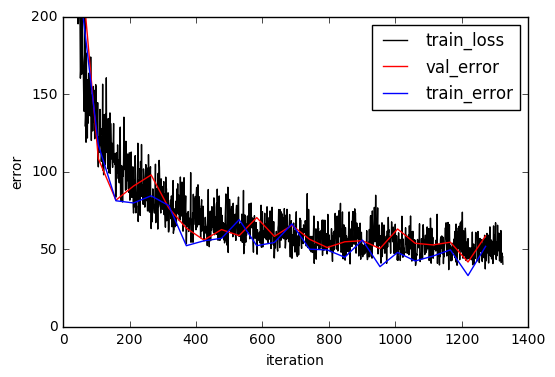

In [67]:
_, ax1 = plt.subplots()
# ax2 = ax1.twinx()
ax1.plot(range(niter), train_loss, 'k', label='train_loss')
ax1.plot(val_interval * np.arange(len(val_error)), val_error, 'r', label='val_error')
ax1.plot(val_interval * np.arange(len(train_error)), train_error, 'b', label='train_error')
ax1.legend()
ax1.set_xlabel('iteration')
ax1.set_ylabel('error')
ax1.set_ylim([0,200])

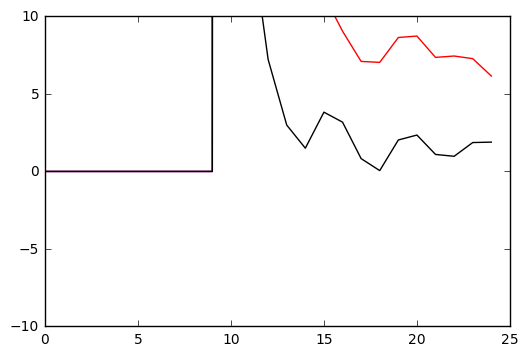

In [68]:
# Determine training auto stop 

mean_10 = np.zeros_like(train_error)
std_10 = np.zeros_like(train_error)
mean_diff_10 = np.zeros_like(train_error)

for idx in range(10, len(train_error)):
    train_error_10 = train_error[idx-10:idx]
    mean_10[idx] = np.mean(train_error_10)
    std_10[idx] = np.std(train_error_10)
    mean_diff_10[idx] = np.abs(np.mean(np.diff(train_error_10)))

plt.plot(range(len(train_error)), mean_10, color='b')
plt.plot(range(len(train_error)), std_10, color='r')
plt.plot(range(len(train_error)), mean_diff_10, color='k')
plt.ylim([-10, 10])
plt.show()



In [69]:
print "training_error = %f, val_error = %f" % (train_error[-1], val_error[-1])
print "training_rmse = %f, val_rmse = %f" % (train_rmse[-1], val_rmse[-1])

training_error = 51.719707, val_error = 58.483105
training_rmse = 1.856874, val_rmse = 1.974557


In [70]:
if 0:
    additional_epochs = 25
    addn_niter = num_iter_per_epoch * additional_epochs
    train_loss_2 = np.append(train_loss, np.zeros(addn_niter))
    train_error_2 = np.append(train_error, np.zeros(int(np.ceil(float(addn_niter) / val_interval))))
    val_error_2 = np.append(val_error, np.zeros(int(np.ceil(float(addn_niter) / val_interval))))

    print "niter = ", niter
    print "addn_niter = ", addn_niter

    for it in range(niter, niter + addn_niter):
        solver.step(1)

        train_loss_2[it] = solver.net.blobs['loss'].data
            
        if (it % val_interval) == 0:

            val_error_this = 0
            for test_it in range(niter_val_error):
                solver.test_nets[0].forward()
                val_error_this += euclidean_loss(solver.test_nets[0].blobs['score'].data , 
                                                 solver.test_nets[0].blobs['label'].data) / niter_val_error
            val_error_2[it // val_interval] = val_error_this

            train_error_this = 0
            for test_it in range(niter_train_error):
                solver.test_nets[1].forward()
                train_error_this += euclidean_loss(solver.test_nets[1].blobs['score'].data , 
                                                 solver.test_nets[1].blobs['label'].data) / niter_train_error
            train_error_2[it // val_interval] = train_error_this


            print "addn_iter = %d, train_loss = %f, train_error = %f, val_error = %f" % (it, train_loss_2[it], train_error_2[it // val_interval], val_error_2[it // val_interval])

In [71]:
if 0:
    _, ax1 = plt.subplots()
    # ax2 = ax1.twinx()
    ax1.plot(val_interval * np.arange(len(val_error_2)), train_error_2, label='train_error')
    ax1.plot(val_interval * np.arange(len(val_error_2)), val_error_2, 'r', label='val_error')
    ax1.legend()
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('error')
    ax1.set_ylim([0,1000])

In [72]:
my_net = solver.net
train_error_sanity = 0
niter_sanity = 1
batch_size_used = 128
for it in range(niter_sanity):
    it_range = range(it*batch_size, it*batch_size+batch_size)
    my_net.blobs['data'].data[...] = X_train_clean_cv[it_range]
    my_net.forward()
    out = my_net.blobs['score'].data
    
    net = my_net
    
    print "data"
    print net.blobs['data'].data.shape
    print net.blobs['data'].data[0:5, 0, 0:5, 0]
    
    print "conv1"
    print net.blobs['conv1'].data.shape
    print net.blobs['conv1'].data[0:5, 0, 0:5, 0]
    
    print "relu1"
    print net.blobs['relu1'].data.shape
    print net.blobs['relu1'].data[0:5, 0, 0:5, 0]
    
    print "pool1"
    print net.blobs['pool1'].data.shape
    print net.blobs['pool1'].data[0:5, 0, 0:5, 0]
    
    
    print "conv2"
    print net.blobs['conv2'].data.shape
    print net.blobs['conv2'].data[0:5, 0, 0:5, 0]
    
    print "relu2"
    print net.blobs['relu2'].data.shape
    print net.blobs['relu2'].data[0:5, 0, 0:5, 0]
    
    print "pool2"
    print net.blobs['pool2'].data.shape
    print net.blobs['pool2'].data[0:5, 0, 0:5, 0]
    
    print "fc1"
    print net.blobs['fc1'].data[0:2,0:5]
    
    print "score"
    print net.blobs['score'].data[0:2]
    
    
    
    
    print "conv1 weights"
    print net.params['conv1'][0].data.shape
    print net.params['conv1'][0].data[0:2][0:5]
    
    print "conv1 biases"
    print net.params['conv1'][1].data.shape
    print net.params['conv1'][1].data[0:5]
    
    print "conv2 weights"
    print net.params['conv2'][0].data.shape
    print net.params['conv2'][0].data[0:2, 0:2, 0:5, 0]
    
    print "conv2 biases"
    print net.params['conv2'][1].data.shape
    print net.params['conv2'][1].data[0:5]
    
    print "fc1 weights"
    print net.params['fc1'][0].data.shape
    print net.params['fc1'][0].data[0:5, 0:5]
    
    print "fc1 biases"
    print net.params['fc1'][1].data.shape
    print net.params['fc1'][1].data[0:5]
    
    print "score weights"
    print net.params['score'][0].data.shape
    print net.params['score'][0].data[0:5, 0:5]
    
    print "score biases"
    print net.params['score'][1].data.shape
    print net.params['score'][1].data[0:5]
    
    
    print "diffs"
    print "conv1 weights"
    print net.params['conv1'][0].diff.shape
    print net.params['conv1'][0].diff[0:2][0:5]
    
    print "conv1 biases"
    print net.params['conv1'][1].diff.shape
    print net.params['conv1'][1].diff[0:5]
    
    print "conv2 weights"
    print net.params['conv2'][0].diff.shape
    print net.params['conv2'][0].diff[0:2, 0:2, 0:5, 0]
    
    print "conv2 biases"
    print net.params['conv2'][1].diff.shape
    print net.params['conv2'][1].diff[0:5]
    
    print "fc1 weights"
    print net.params['fc1'][0].diff.shape
    print net.params['fc1'][0].diff[0:5, 0:5]
    
    print "fc1 biases"
    print net.params['fc1'][1].diff.shape
    print net.params['fc1'][1].diff[0:5]
    
    print "score weights"
    print net.params['score'][0].diff.shape
    print net.params['score'][0].diff[0:5, 0:5]
    
    print "score biases"
    print net.params['score'][1].diff.shape
    print net.params['score'][1].diff[0:5]
    
#     print "loss"
#     print net.params['loss'][0].diff.shape
#     print net.params['loss'][0].diff[0:5]
    
#     train_error += np.sum( (out - y_train_clean_cv[it_range]) ** 2) / float(2* y_train_clean_cv.shape[1])
    train_error_sanity += euclidean_loss(out, y_train_clean_cv[it_range])
train_error_sanity = train_error_sanity / float(niter_sanity)  

print train_error_sanity

data
(64, 1, 96, 96)
[[ 51.15532684  51.15532684  50.15532684  50.15532684  49.15532684]
 [ 34.15532684  50.15532684  43.15532684  17.15532494   2.15532565]
 [ 40.15532684  45.15532684  44.15532684  25.15532494  34.15532684]
 [-68.84467316 -75.84467316 -78.84467316 -61.84467316 -50.84467316]
 [ 88.15532684  92.15532684  93.15532684  95.15532684  95.15532684]]
conv1
(64, 32, 94, 94)
[[  5.0143919    4.82906914   5.29471397   4.59696627   4.87075424]
 [ -2.09058619  -8.97709465  -9.45553684  -2.98021007  -2.62259078]
 [  5.24209452   3.10813594   6.19995403   9.31009769   5.10679722]
 [ -8.28035831  -8.63272858  -9.03186798  -8.95806789 -10.8296566 ]
 [ 10.5344429   10.14520836   9.9926815    7.63729858   7.28507996]]
relu1
(64, 32, 94, 94)
[[  5.0143919    4.82906914   5.29471397   4.59696627   4.87075424]
 [ -0.20905863  -0.89770949  -0.94555372  -0.29802102  -0.2622591 ]
 [  5.24209452   3.10813594   6.19995403   9.31009769   5.10679722]
 [ -0.82803583  -0.86327285  -0.9031868   -0.89

In [73]:
val_error_sanity = 0
niter_sanity = 8
batch_size_used = 64
for it in range(niter_sanity):
    it_range = range(it*batch_size, it*batch_size+batch_size)
    my_net.blobs['data'].data[...] = X_val_clean_cv[it_range]
    my_net.forward()
    out = my_net.blobs['score'].data
    
#     train_error += np.sum( (out - y_train_clean_cv[it_range]) ** 2) / float(2* y_train_clean_cv.shape[1])
    val_error_sanity += euclidean_loss(out, y_val_clean_cv[it_range])
val_error_sanity = val_error_sanity / float(niter_sanity)

print val_error_sanity

299.691596317


In [74]:
val_error_sanity = 0
niter_sanity = 8
batch_size_used = 64
for it in range(niter_sanity):
    it_range = range(it*batch_size, it*batch_size+batch_size)
    solver.test_nets[0].blobs['data'].data[...] = X_val_clean_cv[it_range]
    solver.test_nets[0].forward(start='conv1')
    out = solver.test_nets[0].blobs['score'].data
    
#     train_error += np.sum( (out - y_train_clean_cv[it_range]) ** 2) / float(2* y_train_clean_cv.shape[1])
    val_error_sanity += np.sum ( (out - y_val_clean_cv[it_range]) ** 2)

val_error_sanity = val_error_sanity / float(niter_sanity * 2 * batch_size_used)

print val_error_sanity

59.6047626503


In [75]:
if DEBUG_MSGS:
    print len(conv1_out)
    print conv1_out[0].shape

    for i in range(5):
        conv1_out_i = conv1_out[i]
        print conv1_out_i[0:5, 0, 0:5, 0]

    print len(conv2_out)
    print conv2_out[0].shape

    for i in range(5):
        conv2_out_i = conv2_out[i]
        print conv2_out_i[0:5, 0, 0:5, 0]

    print "conv1 weights and biases"
    print len(conv1_weights)
    print conv1_weights[0].shape
    for i in range(5):
        conv1_weights_i = conv1_weights[i]
        print conv1_weights_i[0:2,0,0:2,0]

    print len(conv1_biases)
    print conv1_biases[0].shape
    for i in range(5):
        conv1_biases_i = conv1_biases[i]
        print conv1_biases_i[0:5]

    print "diff conv1 weights and biases"
    print len(conv1_weights_diff)
    print conv1_weights_diff[0].shape
    for i in range(5):
        conv1_weights_i = conv1_weights_diff[i]
        print conv1_weights_i[0:2,0,0:2,0]

    print len(conv1_biases_diff)
    print conv1_biases_diff[0].shape
    for i in range(5):
        conv1_biases_i = conv1_biases_diff[i]
        print conv1_biases_i[0:5]

    print "conv2 weights and biases"
    print len(conv2_weights)
    print conv2_weights[0].shape
    for i in range(5):
        conv2_weights_i = conv2_weights[i]
        print conv2_weights_i[0:2,0,0:2,0]

    print len(conv2_biases)
    print conv2_biases[0].shape
    for i in range(5):
        conv2_biases_i = conv2_biases[i]
        print conv2_biases_i[0:5]

    print len(conv2_weights_diff)
    print conv2_weights_diff[0].shape
    for i in range(5):
        conv2_weights_i = conv2_weights_diff[i]
        print conv2_weights_i[0:2,0,0:2,0]

    print "diff conv2 weights and biases"
    print len(conv2_biases_diff)
    print conv2_biases_diff[0].shape
    for i in range(5):
        conv2_biases_i = conv2_biases_diff[i]
        print conv2_biases_i[0:5]

    print len(fc1_weights_diff)
    print fc1_weights_diff[0].shape
    for i in range(5):
        fc1_weights_i = fc1_weights_diff[i]
        print fc1_weights_i[0:2,0:5]

    print len(fc1_biases_diff)
    print fc1_biases_diff[0].shape
    for i in range(5):
        fc1_biases_i = fc1_biases_diff[i]
        print fc1_biases_i[0:5]

    print len(score_weights)
    print score_weights[0].shape
    for i in range(5):
        score_weights_i = score_weights[i]
        print score_weights_i[0:30:10,0]

    print len(score_biases)
    print score_biases_diff[0].shape
    for i in range(5):
        score_biases_i = score_biases[i]
        print score_biases_i[0:30:6]

    print len(score_weights_diff)
    print score_weights_diff[0].shape
    for i in range(5):
        score_weights_i = score_weights_diff[i]
        print score_weights_i[0:30:10,0]

    print len(score_biases_diff)
    print score_biases_diff[0].shape
    for i in range(5):
        score_biases_i = score_biases_diff[i]
        print score_biases_i[0:30:6]